<a href="https://colab.research.google.com/github/RaphaelPetit/Toxic-Gas-Detection/blob/main/Toxic_Gas_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path = '/content/drive/MyDrive/Data for Challenges/Toxic Gas Detection/x_train_T9QMMVq.csv'
x_train = pd.read_csv(path)

path2 = '/content/drive/MyDrive/Data for Challenges/Toxic Gas Detection/y_train_R0MqWmu.csv'
y_train = pd.read_csv(path2)


# Getting Insights from the Data

In [ ]:
# Statistical description of x_train
x_description = x_train.describe()

# Correlation between the features (without ID)
corr_matrix = x_train.drop(columns=["ID"]).corr()

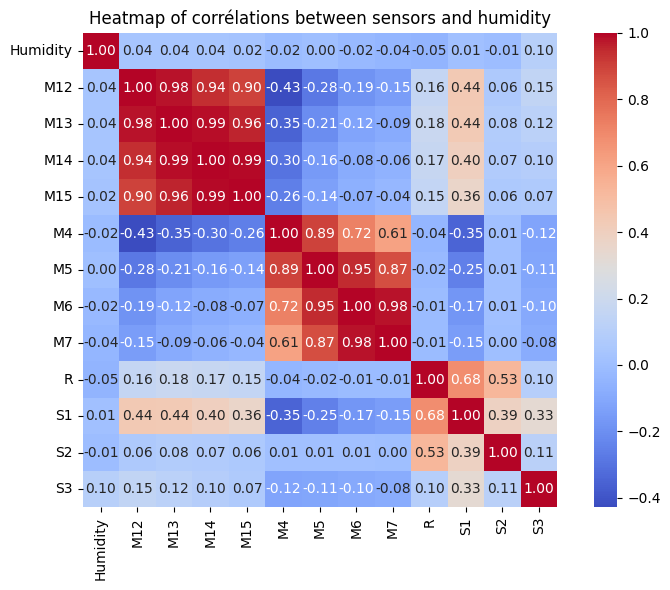

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap of corrélations between sensors and humidity")
plt.tight_layout()
plt.show()


In [ ]:
x_description

,ID,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
count,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000,202933.000000
mean,101466.000000,0.225423,-0.298982,-0.249076,-0.155972,-0.048803,0.891061,0.454768,0.175309,0.080895,1.188765,0.859694,1.014090,1.000640
std,58581.855426,0.335276,1.421943,1.246752,0.848411,0.361638,2.433388,1.578226,0.815405,0.392956,1.828383,0.305172,1.166577,0.023606
min,0.000000,0.000305,-13.021540,-11.844691,-9.117980,-4.165993,-2.831466,-0.790972,-0.224497,-0.147250,0.023324,0.025957,0.151214,0.709661
25%,50733.000000,0.000379,-0.288159,-0.179096,-0.087792,-0.032232,-0.050034,-0.006129,0.002863,0.001548,0.973938,0.773045,0.958714,0.996251
50%,101466.000000,0.090586,-0.000912,0.018658,0.019633,0.012752,0.158831,0.067587,0.035869,0.025857,1.014531,0.931179,0.988017,0.999956
75%,152199.000000,0.328115,0.209746,0.177158,0.120979,0.067154,0.657085,0.259512,0.120237,0.076909,1.121014,0.999371,1.000247,1.008604
max,202932.000000,0.958255,2.545019,2.864641,2.004906,0.842932,28.245698,28.710670,20.508550,10.714200,48.026927,6.626481,55.702963,1.057846


Humidity varies between 0.0003 and 0.95, with a very low median (0.09), so there are quite a few samples with virtually no humidity.
Sensors M4-M7, M12-M15 have very different distributions. Some, like M4 and M5, go up to 28, while others, like M15, are more compact.
R, S1, S2, S3 are all positive, with R rising to 48, and S2 to 55 → extreme values to watch out for

Strong correlation between nearby sensors:
M4, M5, M6, M7 → logical because they are physically neighboring sensors
M12 to M15 also share moderate correlations
Humidity has little direct correlation with other sensors, but could have a non-linear effect

In [ ]:
# Remove ID column
y_only = y_train.drop(columns=["ID"])

Let's calculate the percentage of samples where each class c01 to c23 is ≥ 0.5 (i.e., alarm triggered)

In [ ]:
# Calculate the proportion of alarm triggers (value >= 0.5) for each class
alarm_ratios = (y_only >= 0.5).mean().sort_values(ascending=False)

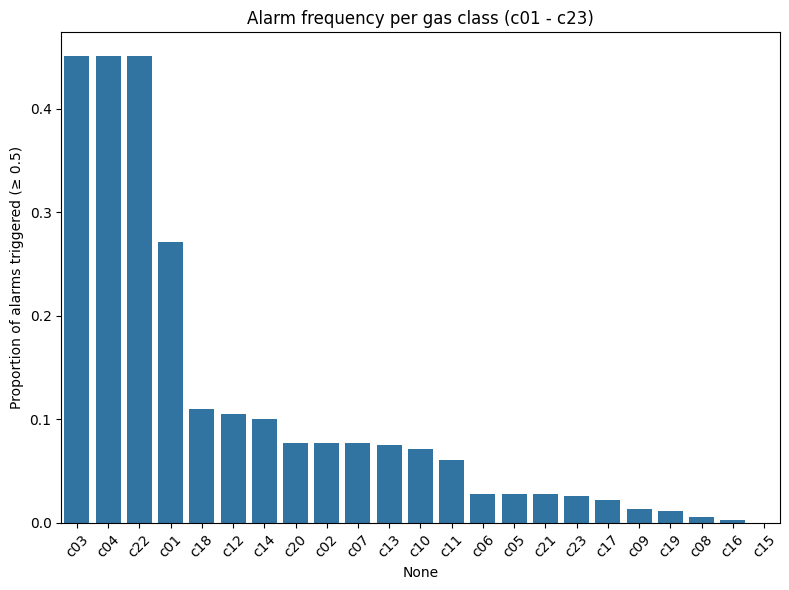

In [ ]:
# Barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=alarm_ratios.index, y=alarm_ratios.values)
plt.xticks(rotation=45)
plt.ylabel("Proportion of alarms triggered (≥ 0.5)")
plt.title("Alarm frequency per gas class (c01 - c23)")
plt.tight_layout()
plt.show()

In [ ]:
alarm_ratios

,0
c03,0.451040
c04,0.451040
c22,0.451040
c01,0.271351
c18,0.110071
c12,0.104783
c14,0.100225
c20,0.077025
c02,0.077025
c07,0.077025


c03, c04, c22: each triggered ~45% of the time — extremely frequent

c01: around 27%

Many others like c15, c16, c08, c19 have extremely rare or even zero alarms

c15 has no alarms at all — might be unlearnable unless it appears in the test set differently

Class imbalance analysis :

Huge variation in alarm frequency — we'll likely need to:

- Weight the loss during training
- Stratify properly in cross-validation (if possible)
- Possibly explore multi-task learning or per-class thresholding later (that can be for futher possible work, maybe out of my range for now)

# Getting insights from merged data (correlations)

In [ ]:
data = pd.merge(x_train, y_train, on='ID')

In [ ]:
data

,ID,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,...,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23
0,0,0.098160,-0.175981,-0.086469,-0.041465,-2.115256e-02,0.197597,0.054646,-0.009277,0.001855,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,1,0.000307,-0.066416,0.036071,0.032636,-5.725724e-04,2.568494,1.883142,0.779251,0.262231,...,0.000000,0.0,0.0,0.0,0.000000,0.176471,0.000000,0.0,0.176471,0.000000
2,2,0.000388,0.190943,0.187540,0.143680,9.263546e-02,-0.147460,-0.021174,0.040079,0.065790,...,0.000000,0.0,0.0,0.0,0.128465,0.000000,0.000000,0.0,0.128465,0.000000
3,3,0.761003,-0.151393,-0.083723,-0.048982,-1.825867e-02,0.045380,0.102427,0.012915,0.004453,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.263736,0.263736
4,4,0.107808,0.074818,0.042692,0.026169,1.913369e-02,-0.056284,-0.011193,0.010233,0.012205,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202928,202928,0.000393,0.044343,0.020466,0.018760,2.282731e-08,-0.067794,-0.005543,-0.012791,-0.011086,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
202929,202929,0.098254,-0.083055,-0.039835,-0.011477,2.914700e-03,1.648845,0.638962,0.150901,0.055199,...,0.142857,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.000000
202930,202930,0.097347,-0.022855,0.000245,-0.011477,2.914700e-03,-0.134655,-0.042388,-0.009412,-0.004919,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
202931,202931,0.000337,-7.681815,-7.377048,-5.311307,-2.185142e+00,15.110632,4.314341,0.763172,0.143616,...,0.528846,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.528846,0.000000


Let's pick a high frequency class : c03 for example

We'll plot M4 vs M5 and M12 vs M13, colored by c03 alarm level because they're physically nearby so they might receive probably correlated signals which is a perfect way to detect local pattern

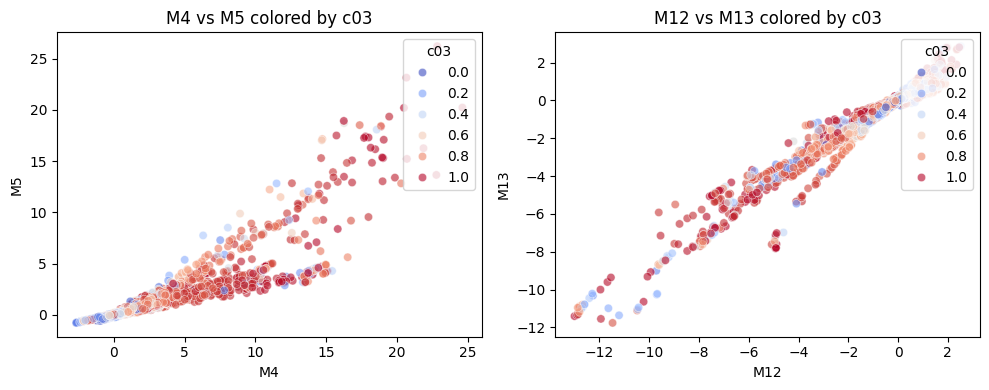

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# M4 vs M5
sns.scatterplot(
    ax=axes[0],
    data=data.sample(10000),  # sampling for performance/visibility
    x="M4",
    y="M5",
    hue="c03",
    palette="coolwarm",
    alpha=0.6
)
axes[0].set_title("M4 vs M5 colored by c03")
axes[0].legend(title="c03", loc="upper right")

# M12 vs M13
sns.scatterplot(
    ax=axes[1],
    data=data.sample(10000),
    x="M12",
    y="M13",
    hue="c03",
    palette="coolwarm",
    alpha=0.6
)
axes[1].set_title("M12 vs M13 colored by c03")
axes[1].legend(title="c03", loc="upper right")

plt.tight_layout()
plt.show()

M4 vs M5:
- There’s a cloud of high-alarm samples in a distinct region of the space.
- Suggests that M4 and M5 together have predictive power for detecting this class.

M12 vs M13:
- Similar situation — a clear gradient of alarm levels depending on the combination of these two sensors.
- The boundary isn't linear, but there's definitely signal here.

This is teh takeaway I identify :
- Sensor combinations can help us separate toxic vs. non-toxic zones
- These interactions are likely nonlinear, so simple linear models may struggle
- We could engineer composite features like:
Ratios (M4 / M5, M12 - M13)
Local gradients (M5 - M4, M13 - M12)

We'll treat the extreme values afterwards (e.g. log for outliers)

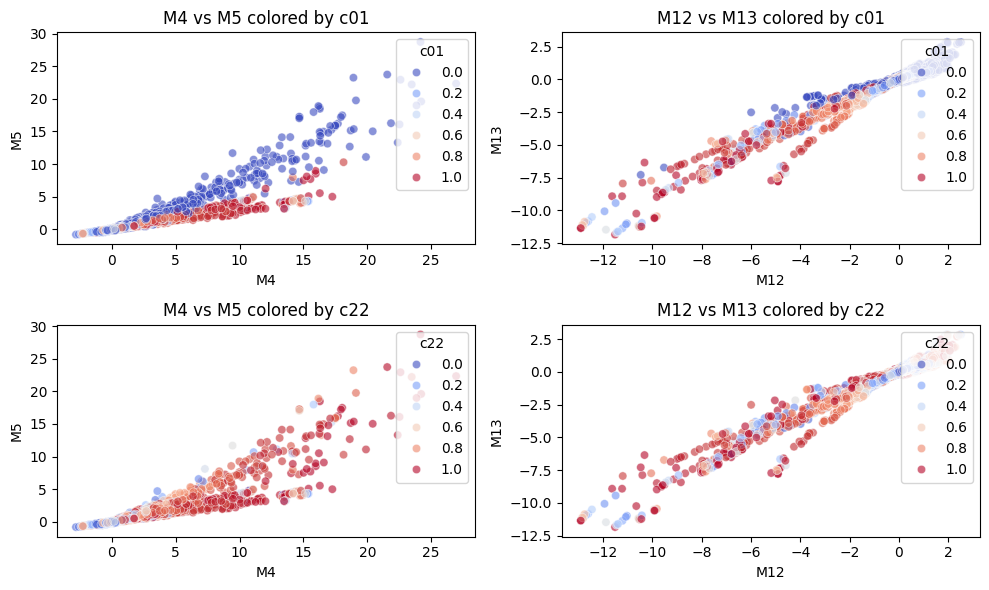

In [ ]:
#Let's build some scatterplots for c01 and c22 (two other very frequen sensors (cf. alarm ratios table in the first section))

sample_data = data.sample(10000)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# M4 vs M5
sns.scatterplot(
    ax=axes[0, 0],
    data=sample_data,
    x="M4",
    y="M5",
    hue="c01",
    palette="coolwarm",
    alpha=0.6
)
axes[0, 0].set_title("M4 vs M5 colored by c01")
axes[0, 0].legend(title="c01", loc="upper right")

# M12 vs M13 for c01
sns.scatterplot(
    ax=axes[0, 1],
    data=sample_data,
    x="M12",
    y="M13",
    hue="c01",
    palette="coolwarm",
    alpha=0.6
)
axes[0, 1].set_title("M12 vs M13 colored by c01")
axes[0, 1].legend(title="c01", loc="upper right")


# M4 vs M5 for c22
sns.scatterplot(
    ax=axes[1, 0],
    data=sample_data,
    x="M4",
    y="M5",
    hue="c22",
    palette="coolwarm",
    alpha=0.6
)
axes[1, 0].set_title("M4 vs M5 colored by c22")
axes[1, 0].legend(title="c22", loc="upper right")

# M12 vs M13 for c22
sns.scatterplot(
    ax=axes[1, 1],
    data=sample_data,
    x="M12",
    y="M13",
    hue="c22",
    palette="coolwarm",
    alpha=0.6
)
axes[1, 1].set_title("M12 vs M13 colored by c22")
axes[1, 1].legend(title="c22", loc="upper right")

plt.tight_layout()
plt.show()

M4vsM5 for c01 :
There is a clear cluster of high alarm values concentrated in a specific region:
- M4 between ~5 and 15
- M5 between ~0 and 5

This forms a horizontal band of red points, indicating that alarms for c01 tend to occur when: M4 is moderately high and M5 remains relatively low

This suggests a nonlinear interaction between M4 and M5 — high values of M4 paired with low M5, makes the alarm more likely to be triggered.




M4vs M5 for c22 : There is a dense region:
- M4 ~ 5 to 10
- M5 ~ 0 to 5

just like for c01, a horizontal band of red points but we also see something different from c01:

For higher values of M4 (>=15) and corresponding higher M5, we still see high alarm values
It's more spread out, but still aligned along a roughly diagonal linear path

This can suggest that c22 is not only triggered in the same tight low-zone as c01, but also in a broader region following the general positive M4-M5 correlation

There's probably more tolerance for higher M5 in c22 than in c01

On the scatterplots M12 vs M13 for both c01 and c22, no clearly separable region or strong clustering (maybe not linear pattern).

Key takeaways :

- For c01, the alarm is sensitive to low M5 despite high M4

- For c22, the alarm is just more likely when both M4 and M5 are simultaneously high (but it also includes the lower band)


# First features

In [ ]:
x_feat = x_train.copy()

In [ ]:
# Sensor Differences

# M4 - M5: captures horizontal band where M4 is high, M5 is low
x_feat["M4_minus_M5"] = x_feat["M4"] - x_feat["M5"]

# M12 - M13: potential weak residual patterns
x_feat["M12_minus_M13"] = x_feat["M12"] - x_feat["M13"]

In [ ]:
# Sensor Ratios & Products

# M4 / M5: highlithgts regions with strong imbalance between M4 and M5 (for c01) (i put the 1e-6 because i had an error of division by zero)
x_feat["M4_div_M5"] = x_feat["M4"] / (x_feat["M5"] + 1e-6)

# M4 * M5: Useful for c22, which shows spread along a diagonal (positive correlation)
x_feat["M4_times_M5"] = x_feat["M4"] * x_feat["M5"]

In [ ]:
# Interaction Flags

# Low M5 and High M4 zone (for c01/c03 clusters)
x_feat["low_M5_high_M4"] = ((x_feat["M4"] > 5) & (x_feat["M5"] < 5)).astype(int)

# High M4 and High M5 zone (for c22/c03 diagonal spread)
x_feat["high_M4_and_M5"] = ((x_feat["M4"] > 15) & (x_feat["M5"] > 10)).astype(int)


In [ ]:
x_feat[["M4", "M5", "M4_minus_M5", "M4_div_M5", "M4_times_M5", "low_M5_high_M4", "high_M4_and_M5"]].head()

,M4,M5,M4_minus_M5,M4_div_M5,M4_times_M5,low_M5_high_M4,high_M4_and_M5
0,0.197597,0.054646,0.142951,3.615879,0.010798,0,0
1,2.568494,1.883142,0.685352,1.363940,4.836839,0,0
2,-0.147460,-0.021174,-0.126286,6.964632,0.003122,0,0
3,0.045380,0.102427,-0.057047,0.443044,0.004648,0,0
4,-0.056284,-0.011193,-0.045092,5.029192,0.000630,0,0


# First model training

No scaling for now since we're only trying tree-based model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import numpy as np

In [ ]:
X = x_feat.drop(columns=["ID"])
y = y_train.drop(columns=["ID"])

In [ ]:
# Sample 10k for quick testing
sample_idx = X.sample(n=10000, random_state=42).index
X_sample = X.loc[sample_idx]
y_sample = y.loc[sample_idx]

In [ ]:
# Split for quick local evaluation (not full CV yet)
X_train, X_val, y_train_split, y_val_split = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# Dictionary to store results
model_results = {}

I'll run models with 10 branches for efficiency sake for now

In [ ]:
# --- Random Forest ---
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train_split)
rf_preds = rf.predict(X_val)

# --- LightGBM ---
lgb_model = MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=10, random_state=42, n_jobs=-1))
lgb_model.fit(X_train, y_train_split)
lgb_preds = lgb_model.predict(X_val)

# --- XGBoost ---
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=10, random_state=42, n_jobs=-1, verbosity=0))
xgb_model.fit(X_train, y_train_split)
xgb_preds = xgb_model.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 19
[LightGBM] [Info] Start training from score 0.278545
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 19
[LightGBM] [Info] Start training from score 0.076097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 

In [ ]:
# Custom metric as per challenge definition
def custom_metric(y_true, y_pred):
    f = np.where(y_true >= 0.5, 1.2, 1.0)
    err = f * (y_true - y_pred) ** 2
    return np.sqrt(err.mean())

# Evaluate all models
model_results["RandomForest"] = custom_metric(y_val_split.values, rf_preds)
model_results["LightGBM"] = custom_metric(y_val_split.values, lgb_preds)
model_results["XGBoost"] = custom_metric(y_val_split.values, xgb_preds)

model_results

{'RandomForest': np.float64(0.05750191191992006),
 'LightGBM': np.float64(0.1166653544781244),
 'XGBoost': np.float64(0.07437590195079347)}

Strange performance actually, too good to be true as it puts me on top5 of the leaderboard over 50 submissions, my bet is that the sampling and the little tuning i made manually maybe overfitted a little the data

I figured we should check if there's target leakage via ID order or grouping in the sampled data. I plotted some stuff for that.

In [ ]:
row_mean_target = y.mean(axis=1)
sampled_means = row_mean_target.sample(n=10000, random_state=42).sort_index()

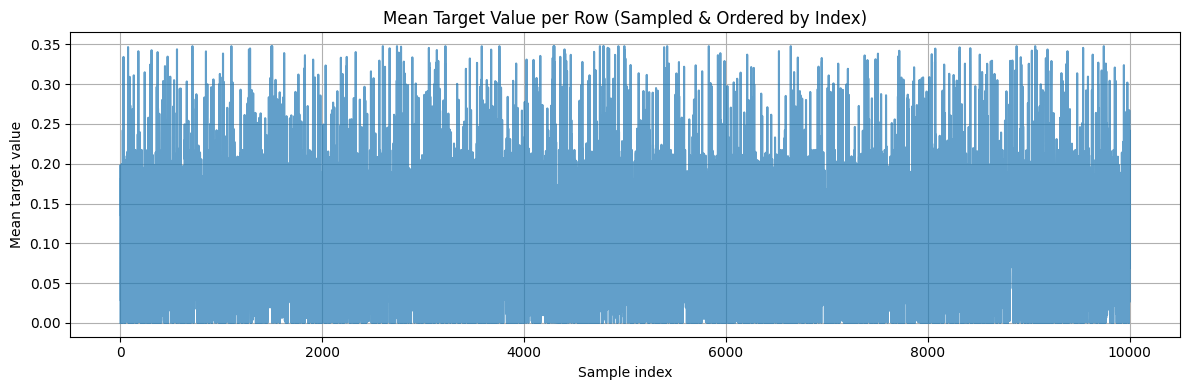

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(sampled_means.values, alpha=0.7)
plt.title("Mean Target Value per Row (Sampled & Ordered by Index)")
plt.xlabel("Sample index")
plt.ylabel("Mean target value")
plt.grid(True)
plt.tight_layout()
plt.show()

Average targets per line are relatively uniform at the top (between ~0.2 and ~0.35).

A few lines have an average close to 0 (very few alarms triggered).

No clear block or step patterns
No visible leakage at first glance.

Despite this conclusive plot, it's a random sample of 10,000 lines (so potentially mixed)

The real test would be to run the plot on the first 10,000 lines to check if there's a “batch” effect, which I 've already seen in a zone from NCAA Outcomes Forecasting

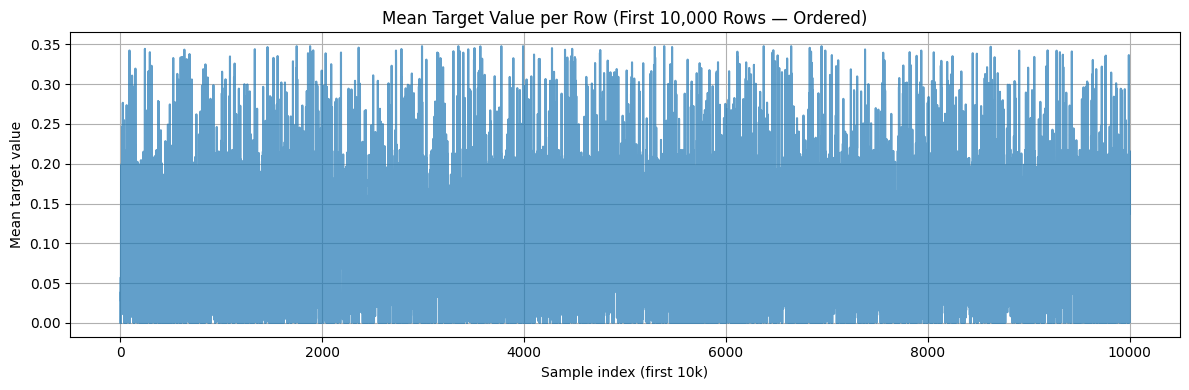

In [ ]:
first_10k_means = y.iloc[:10000].mean(axis=1)

plt.figure(figsize=(12, 4))
plt.plot(first_10k_means.values, alpha=0.7)
plt.title("Mean Target Value per Row (First 10,000 Rows — Ordered)")
plt.xlabel("Sample index (first 10k)")
plt.ylabel("Mean target value")
plt.grid(True)
plt.tight_layout()
plt.show()

No conclusive observations to think there was id leakage, the score might be ok, even a little high for a baseline

We could push this research further with the same reasonning across other sensors (M6, M7, M14, M15) but for now i'll try to dig on another zone of featuring that i think might be interesting after digging on internet about the specific toxic gas detection to gain insights

# Other features

In [ ]:
X = x_train.drop(columns=["ID"])
Y = y_train.drop(columns=["ID"])

In [ ]:
mean_target = Y.mean(axis=1)
sensor_target_corr = X.corrwith(mean_target)

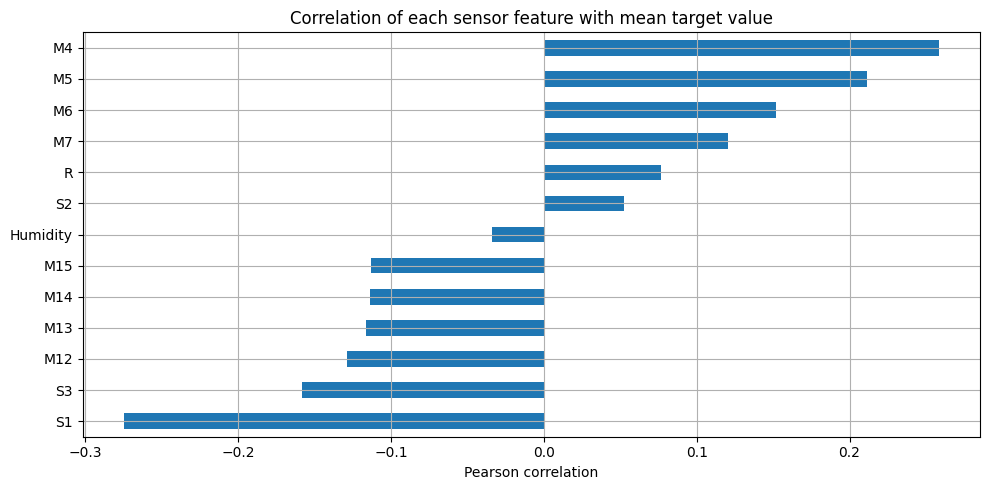

In [ ]:
plt.figure(figsize=(10, 5))
sensor_target_corr.sort_values().plot(kind='barh')
plt.title("Correlation of each sensor feature with mean target value")
plt.xlabel("Pearson correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sensor_target_corr.sort_values(ascending=False)

,0
M4,0.258679
M5,0.211299
M6,0.152201
M7,0.120736
R,0.076738
S2,0.052704
Humidity,-0.033670
M15,-0.112826
M14,-0.113826
M13,-0.116296


Well, first of all, our plot confirm why M4 and M5 were so visually effective

Moreover, S1 seems to be an interesting feature to reverse (as deeply negatively correlated)

As another purely exploratory feature, i'm going to try the S1/S3 ratio (both are negatively correlated to targets), so check if it captures a imbalance such as : when S1 is significantly greater than S3, the alarm activates

In [ ]:
# same as earlier, sensor local gradients, but with none neighbor sensors
x_feat["M6_minus_M4"] = x_feat["M6"] - x_feat["M4"]
x_feat["M7_minus_M5"] = x_feat["M7"] - x_feat["M5"]

#Inverse of S1 (i've looke up how to flip strong negative correlation, same as earlier, the 1e-6 is to avoid division by zero)
x_feat["S1_inverse"] = 1 / (np.abs(x_feat["S1"]) + 1e-6)

x_feat["S1_S3_ratio"] = x_feat["S1"] / (x_feat["S3"] + 1e-6)


A feature that could fit an environmental analysis is the product of a sensor with humidity, because it modifies the sensor measures (can amplify or attenuate a signal)

I chose M12 because the second group of sensors has not been explored that much yet, and they show negative correlation (moderated actually), so I think it's a bet worth to try, further work would imply trying it with M13, M14, M15

In [ ]:
x_feat["humidity_M12"] = x_feat["Humidity"] * x_feat["M12"]

In [ ]:
x_feat[["M6_minus_M4", "M7_minus_M5", "S1_inverse", "S1_S3_ratio", "humidity_M12"]].head()

,M6_minus_M4,M7_minus_M5,S1_inverse,S1_S3_ratio,humidity_M12
0,-0.206875,-0.052791,0.987159,1.013617,-0.017274
1,-1.789243,-1.620910,1.003274,0.983882,-0.000020
2,0.187539,0.086964,1.104635,0.917806,0.000074
3,-0.032465,-0.097974,0.995703,0.994897,-0.115211
4,0.066518,0.023397,0.994871,1.005602,0.008066


# Second modeling try

In [ ]:
#just in case , when i run some blocks and not others
y = y_train.drop(columns=["ID"])
X = x_feat.drop(columns=["ID"])

In [ ]:
#I'm still sampling for fast modeling, quick and brief insight
sample_idx = X.sample(n=10000, random_state=42).index
X_sample = X.loc[sample_idx]
y_sample = y.loc[sample_idx]

In [ ]:
X_train, X_val, y_train_split, y_val_split = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

In [ ]:
model_results = {}

In [ ]:
# --- Random Forest ---
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train_split)
rf_preds = rf.predict(X_val)

# --- LightGBM ---
lgb_model = MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=10, random_state=42, n_jobs=-1))
lgb_model.fit(X_train, y_train_split)
lgb_preds = lgb_model.predict(X_val)

# --- XGBoost ---
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=10, random_state=42, n_jobs=-1, verbosity=0))
xgb_model.fit(X_train, y_train_split)
xgb_preds = xgb_model.predict(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5614
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 24
[LightGBM] [Info] Start training from score 0.278545
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5614
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 24
[LightGBM] [Info] Start training from score 0.076097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5614
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 24
[LightGBM] [Info] Start traini

In [ ]:
# Custom metric as per challenge definition
def custom_metric(y_true, y_pred):
    f = np.where(y_true >= 0.5, 1.2, 1.0)
    err = f * (y_true - y_pred) ** 2
    return np.sqrt(err.mean())

# Evaluate all models
model_results["RandomForest"] = custom_metric(y_val_split.values, rf_preds)
model_results["LightGBM"] = custom_metric(y_val_split.values, lgb_preds)
model_results["XGBoost"] = custom_metric(y_val_split.values, xgb_preds)

model_results

{'RandomForest': np.float64(0.05686787959770671),
 'LightGBM': np.float64(0.11669270671372627),
 'XGBoost': np.float64(0.0727146295626725)}

No sign of leakage, score is solid and reasonable

Further steps are (competition ongoing) :
- expand to full dataset with cross validation
- generalize successful interactions such as humidity with sensors
- explore nonlinear transforms
- model optimization by hyperparameter tuning (randomized search especially if we move on with RF and LGBM)
- consider ensembling

For theorical future steps that i'm still not comfortable with :
- explore misclassified patterns to drive new features
- analyze per-calss performance
- feature combos : clusters like is_in_cluster_zone, creating many clusters, generalizing with KMeans and creating the feature cluster_id, try to create a mapping of risky clusters...